# Discrete Event Simulation: Dining Philosophers



**Task overview**
- 5 philosophers sitting around round table
- 5 chopsticks (one between each pair of philosophers)
- Each philosopher needs 2 chopsticks to eat
- States: Thinking -> Hungry -> Eating -> Thinking

**Tasks implemented:**
1. Basic simulation (100 time units)
2. Deadlock detection
3. Deadlock prevention (priority ordering + timeout strategies)

In [498]:
import heapq
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
from enum import Enum
from collections import deque

from copy import deepcopy

random.seed(54)
np.random.seed(54)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Core Classes and Data Structures

In [499]:
class PhilosopherState(Enum):
    """States philosopher can be in"""
    THINKING = "thinking"
    HUNGRY = "hungry"
    EATING = "eating"


class EventType(Enum):
    """Types of events in the simulation"""
    FINISH_THINKING = "finish_thinking"
    TRY_ACQUIRE_CHOPSTICKS = "try_acquire_chopsticks"
    FINISH_EATING = "finish_eating"
    TIMEOUT_RELEASE = "timeout_release"
    DELAYED_RELEASE = "delayed_release"


@dataclass(order=True)
class Event:
    """Event in the discrete event simulation"""
    time: float
    event_type: EventType = field(compare=False)
    philosopher_id: int = field(compare=False)
    generation: int = field(compare=False, default=0)


class Chopstick:
    """Represents a chopstick resource"""
    def __init__(self, id: int):
        self.id = id
        self.held_by: Optional[int] = None

    def is_available(self) -> bool:
        return self.held_by is None

    def acquire(self, philosopher_id: int) -> bool:
        if self.is_available():
            self.held_by = philosopher_id
            return True
        return False

    def release(self):
        self.held_by = None


class Philosopher:
    """Represents a philosopher with state and behavior"""
    def __init__(self, id: int, left: int, right: int, deadlock_prone: bool = False, 
                 unif_thinking_time: bool = False, think_unif_low: float = 2.0, think_unif_high: float = 30.0,
                 gauss_eating_time: bool = False, eat_mean: float = 5.0, eat_sigma: float = 1.0, eat_gauss_low: float = 1.0, eat_gauss_high: float = 10.0):
        self.id = id
        self.state = PhilosopherState.THINKING
        self.left_chopstick_id = left
        self.right_chopstick_id = right
        self.held_chopsticks: List[int] = []
        self.eat_count = 0
        self.total_thinking_time = 0.0
        self.total_eating_time = 0.0
        self.total_hungry_time = 0.0
        self.last_state_change = 0.0
        self.last_ate_time = 0.0
        self.attempt_start_time = None
        self.generation = 0
        self.deadlock_prone = deadlock_prone

        ## for task 5 ##
        self.unif_thinking_time = unif_thinking_time
        self.think_unif_low = think_unif_low
        self.think_unif_high = think_unif_high

        self.gauss_eating_time = gauss_eating_time
        self.eat_mean = eat_mean
        self.eat_sigma = eat_sigma
        self.eat_gauss_low = eat_gauss_low
        self.eat_gauss_high = eat_gauss_high

        # for selfish philosophers: ignore timeout release rule
        self.ignore_timeout = False     

        # for selfish philosophers: ignore priority ordering -> random ordering of which chopstick to use
        self.random_order = False

        # for selfish philosophers: wait a while before dropping chopsticks after eating
        self.post_eat_hold = 0.0
       


    def get_thinking_time(self):
        # return 0.0 if self.deadlock_prone else random.expovariate(1 / 5)
        if self.deadlock_prone:
            return 0.0
        if self.unif_thinking_time:
            return random.uniform(self.think_unif_low, self.think_unif_high)
        return random.expovariate(1 / 5)

    def get_eating_time(self):
        def truncated_normal() -> float:
            """Sample N(mu, sigma) but reject values outside [lo, hi]."""
            mu = self.eat_mean
            sigma = self.eat_sigma
            lo = self.eat_gauss_low
            hi = self.eat_gauss_high

            
            if self.eat_sigma <= 0:
                return max(lo, min(hi, mu))
            while True:
                x = random.gauss(mu, sigma)
                if lo <= x <= hi:
                    return x
                
        # return random.uniform(0.3, 0.8) if self.deadlock_prone else random.expovariate(1 / 3)
        if self.deadlock_prone:
            return random.uniform(0.3, 0.8)
        if self.gauss_eating_time:
            return truncated_normal()
        return random.expovariate(1 / 3)

    def get_retry_time(self):
        return 0.2 if self.deadlock_prone else random.uniform(0.1, 0.5)#+ random.uniform(0, 1e-6)

    def update_state_time(self, now):
        dt = now - self.last_state_change
        if self.state == PhilosopherState.THINKING:
            self.total_thinking_time += dt
        elif self.state == PhilosopherState.HUNGRY:
            self.total_hungry_time += dt
        elif self.state == PhilosopherState.EATING:
            self.total_eating_time += dt
        self.last_state_change = now


## Simulation Engine

In [500]:
class DiningPhilosophersSimulation:
    """Discrete event simulation of dining philosophers"""

    def __init__(
        self,
        num_philosophers: int = 5,
        deadlock_detection: bool = False,
        prevention_strategy: str = "none",
        starvation_prevention: bool = False,
        timeout_duration: float = 2.0,
        deadlock_prone: bool = False,
        synchronized_start: bool = False,
        force_deadlock_demo: bool = False,
        halt_on_deadlock: bool = False,
        # rest of options is for task 5:
        unif_thinking_time: bool = False,
        think_unif_low: float = 2.0,
        think_unif_high: float = 30.0,
        gauss_eating_time: bool = False,
        eat_mean: float = 5.0,
        eat_sigma: float = 1.0,
        eat_gauss_low: float = 1.0,
        eat_gauss_high: float = 10.0,
        selfish_ids: set = None,
        conspiracy_ids: set = None,
        conspiracy_victim: Optional[int] = None,
        conspiracy_extra_hold: float = 1.0,
        conspiracy_retry_fast: float = 0.02
    ):
        """
        Initialize simulation

        Args:
            num_philosophers: number of philosophers (by default 5)
            deadlock_detection: enable deadlock detection
            prevention_strategy: 'none', 'priority', 'timeout'
            timeout_duration: timeout for releasing chopsticks
            deadlock_prone: use tighter think/eat times to increase contention
            synchronized_start: have all philosophers start hungry at t=0 (for detection demo)
            force_deadlock_demo: force everyone to hold left chopstick at t=0 (demo only)
            halt_on_deadlock: if True, stop simulation on first deadlock (default: False)
        """
        self.num_philosophers = num_philosophers
        self.current_time = 0.0
        self.event_queue = []
        self.deadlock_detection = deadlock_detection
        self.prevention_strategy = prevention_strategy
        self.starvation_prevention = starvation_prevention
        self.timeout_duration = timeout_duration
        self.deadlock_prone = deadlock_prone
        self.synchronized_start = synchronized_start
        self.force_deadlock_demo = force_deadlock_demo
        self.in_deadlock = False       # latch to avoid multiple counts per deadlock
        self.halt_on_deadlock = halt_on_deadlock
        self.halted = False            # track if simulation was halted

        self.timeout_release_count = 0  # counts how often timeout release was triggered
        # self.timeout_release_count = 0 if prevention_strategy == "timeout" else None

        # queues for starvation prevention
        self.hungry_queue = deque()
        self.in_queue = set()

        # stats
        self.deadlock_count = 0
        self.deadlock_times = []

        # persistent deadlock tracking (for timeout evaluation)
        self.progress_time = 0.0
        self.deadlock_active = False
        self.deadlock_start_time = None
        self.persistent_deadlock_count = 0
        self.persistent_deadlock_times = []
        self.persistent_deadlock_window = 3.0 * self.timeout_duration
        self.persistent_deadlock_counted = False

        # for conspiracy in task 5
        self.conspiracy_ids = set(conspiracy_ids or [])
        self.conspiracy_victim = conspiracy_victim
        self.conspiracy_extra_hold = conspiracy_extra_hold
        self.conspiracy_retry_fast = conspiracy_retry_fast


        self.event_log = []

        # resources
        self.chopsticks = [Chopstick(i) for i in range(num_philosophers)]

        # philosophers
        # stores id's of selfish philosophers
        self.selfish_ids = set(selfish_ids or [])

        self.philosophers = []
        for i in range(num_philosophers):
            left = i
            right = (i + 1) % num_philosophers
            self.philosophers.append(
                Philosopher(
                    i, left, right, deadlock_prone,
                    unif_thinking_time, think_unif_low, think_unif_high,
                    gauss_eating_time, eat_mean, eat_sigma, eat_gauss_low, eat_gauss_high
                )
            )

        # for task 5: configure selfish philosophers (only if no conspiracy)
        if not self.conspiracy_ids:
            for p in self.philosophers:
                if p.id in self.selfish_ids:
                    
                    if prevention_strategy == "timeout":
                        p.ignore_timeout = True
                    else:
                        p.random_order = True

                    p.post_eat_hold = 1.0   

        if synchronized_start:
            # everyone hungry at t=0, no chopsticks yet
            for phil in self.philosophers:
                phil.state = PhilosopherState.HUNGRY
                if self.starvation_prevention and phil.id not in self.in_queue:
                    self.hungry_queue.append(phil.id)
                    self.in_queue.add(phil.id)
                phil.last_state_change = 0.0
                self.schedule_event(Event(0.0, EventType.TRY_ACQUIRE_CHOPSTICKS, phil.id, phil.generation))
        else:
            # Normal initialization: everyone starts thinking
            for phil in self.philosophers:
                thinking_time = phil.get_thinking_time()
                self.schedule_event(Event(thinking_time, EventType.FINISH_THINKING, phil.id))

        # Optional demo: force immediate circular wait (everyone holds left)
        if force_deadlock_demo:
            for phil in self.philosophers:
                phil.state = PhilosopherState.HUNGRY
                if self.starvation_prevention and phil.id not in self.in_queue:
                    self.hungry_queue.append(phil.id)
                    self.in_queue.add(phil.id)
                phil.held_chopsticks = [phil.left_chopstick_id]
                self.chopsticks[phil.left_chopstick_id].held_by = phil.id
                phil.last_state_change = 0.0
                self.schedule_event(Event(0.0, EventType.TRY_ACQUIRE_CHOPSTICKS, phil.id, phil.generation))

    def schedule_event(self, event: Event):
        """Add event to priority queue"""
        # event.time += random.uniform(0, 1e-9)
        heapq.heappush(self.event_queue, event)

    def log_event(self, description: str):
        """Log simulation event"""
        self.event_log.append({
            'time': self.current_time,
            'description': description
        })

    def get_chopstick_order(self, philosopher: Philosopher) -> Tuple[int, int]:
        """Get chopstick acquisition order based on prevention strategy"""
        left = philosopher.left_chopstick_id
        right = philosopher.right_chopstick_id

        # selfish ignores priority: random left/right first
        if philosopher.random_order:
            return (left, right) if random.random() < 0.5 else (right, left)

        # --- CONSPIRACY: targeted blocking order (only when victim is hungry) ---
        if self.conspiracy_ids and philosopher.id in self.conspiracy_ids and self.conspiracy_active():
            v = self.conspiracy_victim
            n = self.num_philosophers

            # victim critical chopsticks: {v, v+1}
            c_left  = v
            c_right = (v + 1) % n

            # the conspirators should be the neighbors of the victim
            left_neighbor  = (v - 1) % n
            right_neighbor = (v + 1) % n

            # left neighbor blocks chopstick v, right neighbor blocks chopstick v+1
            if philosopher.id == left_neighbor:
                target = c_left
            elif philosopher.id == right_neighbor:
                target = c_right
            else:
                target = None  # conspirator not adjacent -> no targeted block

            # If the target is one of my two chopsticks, try it first
            if target is not None:
                if target == left and right != left:
                    return (left, right)
                if target == right and left != right:
                    return (right, left)
            # fall through if not applicable

        # normal behavior
        if self.prevention_strategy == "priority":
            return (min(left, right), max(left, right))

        return (left, right)

        # # normal behavior
        # if self.prevention_strategy == "priority":
        #     return (min(left, right), max(left, right))

        # return (left, right)

    def _cleanup_hungry_queue(self):
        """Remove stale IDs at the front (keeps queue usable without full rescans)."""
        while self.hungry_queue and self.philosophers[self.hungry_queue[0]].state != PhilosopherState.HUNGRY:
            pid = self.hungry_queue.popleft()
            self.in_queue.discard(pid)

    def _pick_starvation_priority(self) -> Optional[int]:
        """
        Starvation avoidance: pick the hungry philosopher with the longest
        time since last ate (current_time - last_ate_time).
        """
        if not self.hungry_queue:
            return None

        best_id = None
        best_score = None
        for pid in self.hungry_queue:
            p = self.philosophers[pid]
            if p.state != PhilosopherState.HUNGRY:
                continue
            score = self.current_time - p.last_ate_time
            if best_id is None or score > best_score or (score == best_score and pid < best_id):
                best_id = pid
                best_score = score
        return best_id

    def try_acquire_chopsticks(self, philosopher: Philosopher) -> bool:
        """Two-phase acquire: take first chopstick, then try for second later"""
        first_id, second_id = self.get_chopstick_order(philosopher)
        first_chopstick = self.chopsticks[first_id]
        second_chopstick = self.chopsticks[second_id]

        has_first = first_id in philosopher.held_chopsticks
        has_second = second_id in philosopher.held_chopsticks

        # Step 1: grab the first if not already holding it
        if not has_first:
            if first_chopstick.acquire(philosopher.id):
                philosopher.held_chopsticks.append(first_id)
            else:
                return False
            # give everyone time to grab their first chopstick
            return False

        # Step 2: try to grab the second
        if not has_second:
            if second_chopstick.acquire(philosopher.id):
                philosopher.held_chopsticks.append(second_id)
                return True
            else:
                if self.prevention_strategy == "timeout" and philosopher.attempt_start_time is None:
                    philosopher.attempt_start_time = self.current_time
                    self.schedule_event(Event(
                        self.current_time + self.timeout_duration,
                        EventType.TIMEOUT_RELEASE,
                        philosopher.id,
                        philosopher.generation
                    ))
                return False

        # Already holding both
        return True

    def release_one(self, philosopher: Philosopher, cid: int):
        if cid in philosopher.held_chopsticks:
            self.chopsticks[cid].release()
            philosopher.held_chopsticks.remove(cid)
 

    def release_chopsticks(self, philosopher: Philosopher):
        """Release all held chopsticks"""
        for chopstick_id in philosopher.held_chopsticks:
            self.chopsticks[chopstick_id].release()
        philosopher.held_chopsticks = []
        philosopher.attempt_start_time = None
        # philosopher.generation += 1  # invalidate pending events for this philosopher

    def check_deadlock(self) -> bool:
        """
        Check if system is in deadlock.
        Deadlock = all philosophers hungry AND each holds exactly one chopstick (circular wait).
        This is a structural condition — detected immediately, no time delay needed.
        """
        if not self.deadlock_detection:
            return False

        hungry_count = sum(1 for p in self.philosophers if p.state == PhilosopherState.HUNGRY)
        if hungry_count == self.num_philosophers:
            holding_one = sum(1 for p in self.philosophers if len(p.held_chopsticks) == 1)
            if holding_one == self.num_philosophers:
                return True  # circular wait confirmed
        return False

    def kick_front(self):
        if not self.starvation_prevention:
            return
        self._cleanup_hungry_queue()
        chosen_id = self._pick_starvation_priority()
        if chosen_id is None:
            return
        chosen = self.philosophers[chosen_id]
        # schedule a single immediate attempt for the chosen philosopher
        self.schedule_event(Event(self.current_time, EventType.TRY_ACQUIRE_CHOPSTICKS, chosen_id, chosen.generation))


    def handle_finish_thinking(self, philosopher: Philosopher):
        philosopher.update_state_time(self.current_time)
        philosopher.state = PhilosopherState.HUNGRY

        if self.starvation_prevention:
            if philosopher.id not in self.in_queue:
                self.hungry_queue.append(philosopher.id)
                self.in_queue.add(philosopher.id)

            self.log_event(f"Philosopher {philosopher.id} is now HUNGRY")
            self.kick_front()
            return

        self.log_event(f"Philosopher {philosopher.id} is now HUNGRY")
        self.schedule_event(Event(self.current_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))


    def handle_try_acquire(self, philosopher: Philosopher):
        if philosopher.state != PhilosopherState.HUNGRY:
            return

        success = self.try_acquire_chopsticks(philosopher)

        if success:
            philosopher.update_state_time(self.current_time)
            philosopher.state = PhilosopherState.EATING
            philosopher.attempt_start_time = None

            # progress happened (someone eats)
            self.progress_time = self.current_time

            if self.starvation_prevention and philosopher.id in self.in_queue:
                self.in_queue.discard(philosopher.id)
                try:
                    self.hungry_queue.remove(philosopher.id)
                except ValueError:
                    pass

            philosopher.eat_count += 1
            philosopher.last_ate_time = self.current_time
            self.in_deadlock = False  # clear latch on progress
            self.log_event(f"Philosopher {philosopher.id} is now EATING (count: {philosopher.eat_count})")
            eating_time = philosopher.get_eating_time()
            self.schedule_event(Event(self.current_time + eating_time, EventType.FINISH_EATING, philosopher.id, philosopher.generation))
        else:
            # retry_time = philosopher.get_retry_time()
            retry_time = philosopher.get_retry_time()
            # if philosopher.id in self.conspiracy_ids and self.conspiracy_active():
            #     retry_time = min(retry_time, self.conspiracy_retry_fast)
            # conspiracy: conspirators retry faster
            if self.conspiracy_ids and philosopher.id in self.conspiracy_ids and self.conspiracy_active():
                retry_time = min(retry_time, self.conspiracy_retry_fast)

            # conspiracy: victim retries slower (starvation pressure)
            if self.conspiracy_ids and philosopher.id == self.conspiracy_victim and self.conspiracy_active():
                retry_time = max(retry_time, 0.5) 

            self.schedule_event(Event(self.current_time + retry_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))

    def conspiracy_active(self) -> bool:
        v = self.conspiracy_victim
        return (v is not None) and (self.philosophers[v].state == PhilosopherState.HUNGRY)

    def victim_critical_chopsticks(self) -> set:
        v = self.conspiracy_victim
        if v is None:
            return set()
        return {v, (v + 1) % self.num_philosophers}


    def handle_finish_eating(self, philosopher: Philosopher):
        self.log_event(f"FINISH_EATING handled for {philosopher.id} (gen={philosopher.generation})")
        philosopher.update_state_time(self.current_time)

        philosopher.attempt_start_time = None
        
        hold = 0.0 # default

        # selfish mode only when conspiracy is inactive
        if not self.conspiracy_ids:
            hold = getattr(philosopher, "post_eat_hold", 0.0)

        if self.conspiracy_ids and philosopher.id in self.conspiracy_ids and self.conspiracy_active():
            v = self.conspiracy_victim
            n = self.num_philosophers

            left_neighbor  = (v - 1) % n
            right_neighbor = (v + 1) % n

            # target chopstick to block the victim
            if philosopher.id == left_neighbor:
                target = v                  # blocks victim's left chopstick
            elif philosopher.id == right_neighbor:
                target = (v + 1) % n        # blocks victim's right chopstick
            else:
                target = None

            if target is not None and target in philosopher.held_chopsticks:
                hold = self.conspiracy_extra_hold

                # release all other chopsticks immediately (partial release)
                for cid in philosopher.held_chopsticks.copy():
                    if cid != target:
                        self.release_one(philosopher, cid)

                self.log_event(
                    f"Conspiracy: Philosopher {philosopher.id} holds only chopstick {target} for {hold:.2f} "
                    f"to block victim {v}"
                )
            else:
                # if we cannot hold the target (not held), do not hold anything extra
                hold = 0.0


        # selfish does not drop chopsticks directly after eating ---
        if hold > 0.0 and len(philosopher.held_chopsticks) > 0:
            self.log_event(f"Philosopher {philosopher.id} finished EATING but holds chopsticks for {hold:.2f} (selfish/conspiracy)")
            self.schedule_event(Event(
                self.current_time + hold,
                EventType.DELAYED_RELEASE,
                philosopher.id,
                philosopher.generation
            ))
        else:
            self.release_chopsticks(philosopher)
        
        philosopher.state = PhilosopherState.THINKING
        self.in_deadlock = False  # clear latch on progress
        self.log_event(f"Philosopher {philosopher.id} is now THINKING")
        thinking_time = philosopher.get_thinking_time()
        self.schedule_event(Event(self.current_time + thinking_time, EventType.FINISH_THINKING, philosopher.id))
        self.kick_front()

    def handle_delayed_release(self, philosopher: Philosopher):
        if len(philosopher.held_chopsticks) > 0:
            self.log_event(f"Philosopher {philosopher.id} releases chopsticks after post-eat hold")
            self.release_chopsticks(philosopher)


    def handle_timeout_release(self, philosopher: Philosopher):
        if philosopher.state == PhilosopherState.HUNGRY and len(philosopher.held_chopsticks) > 0:
            
            # selfish ignores timeout 
            if getattr(philosopher, "ignore_timeout", False):
                self.log_event(f"Philosopher {philosopher.id} TIMEOUT ignored (selfish) - keeps chopsticks")
                philosopher.attempt_start_time = None 
                return
            
            self.log_event(f"Philosopher {philosopher.id} TIMEOUT - releasing chopsticks")
            self.release_chopsticks(philosopher)
            philosopher.generation += 1
            self.timeout_release_count += 1
            self.in_deadlock = False  # clear latch after forced release
            retry_time = philosopher.get_retry_time()
            self.schedule_event(Event(self.current_time + retry_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))
            self.kick_front()

    def process_event(self, event: Event):
        self.current_time = event.time
        philosopher = self.philosophers[event.philosopher_id]

        if event.event_type == EventType.FINISH_THINKING:
            self.handle_finish_thinking(philosopher)

        elif event.event_type == EventType.TRY_ACQUIRE_CHOPSTICKS:
            if self.starvation_prevention:
                self._cleanup_hungry_queue()
                chosen_id = self._pick_starvation_priority()
                if chosen_id is None:
                    return

                chosen = self.philosophers[chosen_id]

                # Only the chosen philosopher is allowed to try
                if event.philosopher_id != chosen_id:
                    return
                if event.generation != chosen.generation:
                    return

                self.handle_try_acquire(chosen)
            else:
                # Baseline: the philosopher tied to this event tries
                if event.generation == philosopher.generation:  # ignore stale retries
                    self.handle_try_acquire(philosopher)

        elif event.event_type == EventType.FINISH_EATING:
            if event.generation == philosopher.generation:
                self.handle_finish_eating(philosopher)
            else:
                self.log_event(f"STALE FINISH_EATING for {philosopher.id} (event gen {event.generation}, cur gen {philosopher.generation})")

        elif event.event_type == EventType.TIMEOUT_RELEASE:
            if event.generation == philosopher.generation:
                self.handle_timeout_release(philosopher)

        elif event.event_type == EventType.DELAYED_RELEASE:
            # if event.generation == philosopher.generation:
            self.handle_delayed_release(philosopher)

        is_deadlock = self.check_deadlock()

        # --- A) track structural deadlock episode (independent of counting deadlock occurrences) ---
        if is_deadlock:
            if not self.deadlock_active:
                self.deadlock_active = True
                self.deadlock_start_time = self.current_time
                self.persistent_deadlock_counted = False  # new episode, not yet counted
        else:
            self.deadlock_active = False
            self.deadlock_start_time = None
            self.persistent_deadlock_counted = False

        # --- B) count "deadlock occurrences" ---
        if is_deadlock:
            if not self.in_deadlock:
                self.in_deadlock = True
                self.deadlock_count += 1
                self.deadlock_times.append(self.current_time)
                self.log_event(f"DEADLOCK DETECTED! (occurrence #{self.deadlock_count})")

                # halt only for non-timeout
                if self.halt_on_deadlock and self.prevention_strategy != "timeout":
                    self.halted = True
                    self.log_event("SIMULATION HALTED DUE TO DEADLOCK")
                    return

                # breaker only for non-timeout
                if self.prevention_strategy != "timeout":
                    longest_hungry = None
                    max_wait = -1.0
                    for p in self.philosophers:
                        if p.state == PhilosopherState.HUNGRY:
                            wait_time = self.current_time - p.last_state_change
                            if wait_time > max_wait or (wait_time == max_wait and (longest_hungry is None or p.id < longest_hungry.id)):
                                max_wait = wait_time
                                longest_hungry = p

                    if longest_hungry:
                        needed_chopstick_id = None
                        for cid in (longest_hungry.left_chopstick_id, longest_hungry.right_chopstick_id):
                            if cid not in longest_hungry.held_chopsticks:
                                needed_chopstick_id = cid
                                break

                        if needed_chopstick_id is not None:
                            holder_id = self.chopsticks[needed_chopstick_id].held_by
                            if holder_id is not None:
                                holder = self.philosophers[holder_id]
                                self.log_event(
                                    f"Breaking deadlock: Philosopher {holder.id} releases chopstick {needed_chopstick_id} "
                                    f"for Philosopher {longest_hungry.id}"
                                )
                                self.release_chopsticks(holder)

                                # allow re-detection
                                self.in_deadlock = False

                                retry_time = holder.get_retry_time()
                                self.schedule_event(Event(
                                    self.current_time + retry_time,
                                    EventType.TRY_ACQUIRE_CHOPSTICKS,
                                    holder.id,
                                    holder.generation
                                ))
                                self.kick_front()
        else:
            self.in_deadlock = False

        # Persistent = structural deadlock holds continuously for a time window.
        if self.prevention_strategy == "timeout" and self.deadlock_active and not self.persistent_deadlock_counted:
            if self.deadlock_start_time is not None:
                if (self.current_time - self.deadlock_start_time) >= self.persistent_deadlock_window:
                    self.persistent_deadlock_count += 1
                    self.persistent_deadlock_times.append(self.deadlock_start_time)
                    self.persistent_deadlock_counted = True
                    self.log_event(
                        f"PERSISTENT DEADLOCK (structural deadlock for "
                        f"{self.persistent_deadlock_window:.2f}) "
                        f"(#{self.persistent_deadlock_count})"
                    )

    def run(self, max_time: float = 100.0):
        while self.event_queue and self.event_queue[0].time <= max_time:
            if self.halted:
                break
            event = heapq.heappop(self.event_queue)
            self.process_event(event)

        for phil in self.philosophers:
            phil.update_state_time(max_time if not self.halted else self.current_time)

        if not self.halted:
            self.current_time = max_time

    def print_statistics(self):
        print(f"Simulation Statistics (Time: 0 to {self.current_time:.2f})")
        print(f"Strategy: {self.prevention_strategy.upper()}")

        if self.prevention_strategy == "timeout":
            print(f"Timeout Duration: {self.timeout_duration}")

        if self.deadlock_prone:
            print("Deadlock-prone timing: tighter think/eat times")

        if self.synchronized_start:
            print("Synchronized start: all hungry at t=0")

        if self.halted:
            print("*** SIMULATION HALTED DUE TO DEADLOCK ***")

        print()
        print(f"{'Philosopher':<12} {'Eat Count':<12} {'Thinking %':<15} {'Hungry %':<15} {'Eating %':<15}")

        for phil in self.philosophers:
            think_pct = (phil.total_thinking_time / self.current_time) * 100 if self.current_time > 0 else 0
            hungry_pct = (phil.total_hungry_time / self.current_time) * 100 if self.current_time > 0 else 0
            eat_pct = (phil.total_eating_time / self.current_time) * 100 if self.current_time > 0 else 0
            print(f"{phil.id:<12} {phil.eat_count:<12} {think_pct:<15.1f} {hungry_pct:<15.1f} {eat_pct:<15.1f}")

        print()
        total_eats = sum(p.eat_count for p in self.philosophers)
        avg_eats = total_eats / self.num_philosophers
        print(f"Total Eats: {total_eats}")
        print(f"Average Eats per Philosopher: {avg_eats:.2f}")

        if self.deadlock_detection:
            print(f"\nDeadlocks Detected: {self.deadlock_count}")
            if self.deadlock_times:
                preview = self.deadlock_times[:5]
                suffix = "..." if len(self.deadlock_times) > 5 else ""
                print(f"Deadlock Times: {preview}{suffix}")

    def get_run_summary(self) -> dict:
        # pro-philosopher totals
        think = [p.total_thinking_time for p in self.philosophers]
        hungry = [p.total_hungry_time for p in self.philosophers]
        eat = [p.total_eating_time for p in self.philosophers]

        return {
            # per philosopher (vectors)
            "think_times": think,
            "hungry_times": hungry,
            "eat_times": eat,
            "eat_counts": [p.eat_count for p in self.philosophers],

            # run-level means over philosophers (scalars)
            "mean_think_time": sum(think) / self.num_philosophers,
            "mean_hungry_time": sum(hungry) / self.num_philosophers,
            "mean_eat_time": sum(eat) / self.num_philosophers,

            # your existing run-level stats if you want them in MC
            "deadlock_count": self.deadlock_count,
            "persistent_deadlock_count": self.persistent_deadlock_count,
            "timeout_release_count": self.timeout_release_count,
            "halted": self.halted,
            "final_time": self.current_time,
        }



# Task 1: Basic Simulation

Simulate 5 philosophers for 100 time units and track eating counts.

In [501]:
random.seed(100)
np.random.seed(100)
sim1 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=False,
    prevention_strategy="none"
)
sim1.run(max_time=120.0)
sim1.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: NONE

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            2            1.5             92.2            6.3            
1            1            3.5             88.2            8.3            
2            0            6.1             93.9            0.0            
3            1            12.2            87.2            0.6            
4            0            5.5             94.5            0.0            

Total Eats: 4
Average Eats per Philosopher: 0.80


## our own comments
first we start our story that we did basic simulation without any deadlock detection and prevention (they are forcibly broken just to finish the simulation) just to see if the logic engine is works. \
in the report we will mention also MC results. \
add the MC run after each task and move fucntions in core engine cell. \
we add only MC results in the report, only in the notebokk we have solo and MC runs \
dont forget to comment the code for instructor

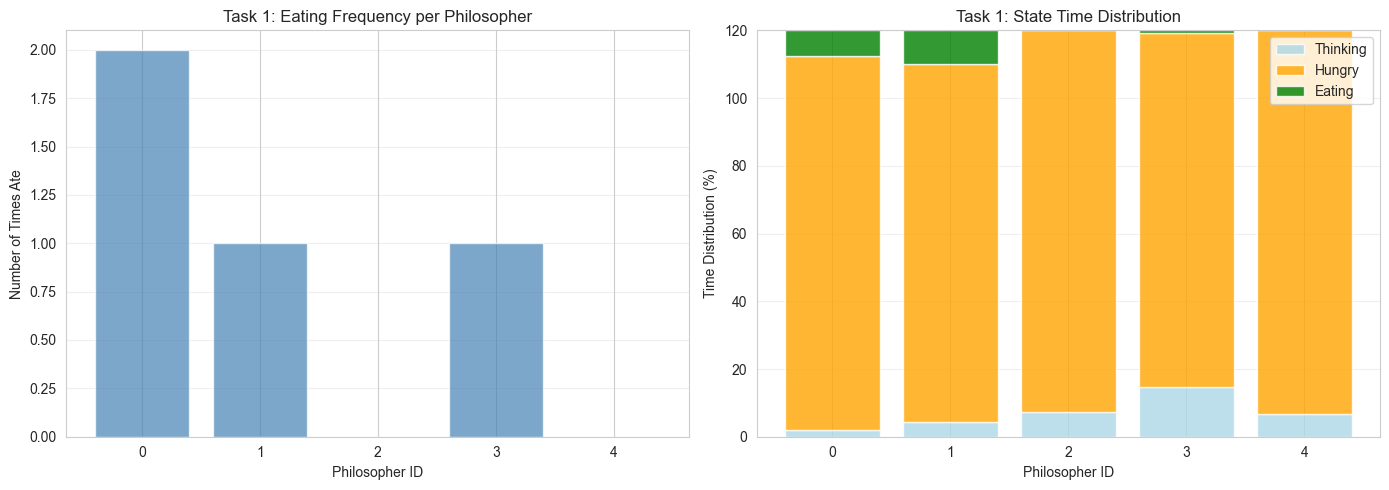

In [502]:
# task 1 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart of eat counts
eat_counts = [p.eat_count for p in sim1.philosophers]
axes[0].bar(range(5), eat_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Philosopher ID')
axes[0].set_ylabel('Number of Times Ate')
axes[0].set_title('Task 1: Eating Frequency per Philosopher')
axes[0].set_xticks(range(5))
axes[0].grid(axis='y', alpha=0.3)

# bar chart of time distribution
thinking_pct = [p.total_thinking_time / 100 * 100 for p in sim1.philosophers]
hungry_pct = [p.total_hungry_time / 100 * 100 for p in sim1.philosophers]
eating_pct = [p.total_eating_time / 100 * 100 for p in sim1.philosophers]

x = np.arange(5)
axes[1].bar(x, thinking_pct, label='Thinking', color='lightblue', alpha=0.8)
axes[1].bar(x, hungry_pct, bottom=thinking_pct, label='Hungry', color='orange', alpha=0.8)
axes[1].bar(x, eating_pct, bottom=np.array(thinking_pct) + np.array(hungry_pct), label='Eating', color='green', alpha=0.8)
axes[1].set_xlabel('Philosopher ID')
axes[1].set_ylabel('Time Distribution (%)')
axes[1].set_title('Task 1: State Time Distribution')
axes[1].set_xticks(range(5))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Task 2: Deadlock Detection

Enable deadlock detection to identify when all philosophers are hungry with one chopstick each.

In [503]:
random.seed(100)
np.random.seed(100)

sim2 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="none",
    halt_on_deadlock=True
)

sim2.run(max_time=120.0)
sim2.print_statistics()

Simulation Statistics (Time: 0 to 19.26)
Strategy: NONE
*** SIMULATION HALTED DUE TO DEADLOCK ***

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            2            9.6             51.1            39.3           
1            1            21.8            26.7            51.5           
2            0            38.2            61.8            0.0            
3            1            76.0            20.3            3.7            
4            0            34.2            65.8            0.0            

Total Eats: 4
Average Eats per Philosopher: 0.80

Deadlocks Detected: 1
Deadlock Times: [19.260710064479532]


# Task 3: Deadlock Prevention

Implement two prevention strategies:
1. **Priority Ordering**: Always pick lower chopstick first
2. **Timeout Strategy**: Release chopsticks after timeout and retry

In [504]:
# S1: Priority Ordering
random.seed(100)
np.random.seed(100)
sim3a = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="priority",
    deadlock_prone=False,          # important for fairness
    synchronized_start=False       # avoid forced crowding
)

sim3a.run(max_time=120.0)
sim3a.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: PRIORITY

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            6            56.9            29.7            13.5           
1            12           30.3            27.4            42.3           
2            11           36.8            39.5            23.6           
3            11           60.8            24.0            15.2           
4            9            45.1            24.4            30.5           

Total Eats: 49
Average Eats per Philosopher: 9.80

Deadlocks Detected: 0


In [505]:
# S2: Timeout Strategy
random.seed(200)
np.random.seed(200)
sim3b = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="timeout",
    timeout_duration=2.0,
    deadlock_prone=False,          # important for fairness
    synchronized_start=False
)

sim3b.run(max_time=120.0)
sim3b.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: TIMEOUT
Timeout Duration: 2.0

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            11           52.2            22.2            25.6           
1            11           51.5            19.7            28.8           
2            13           49.0            37.8            13.1           
3            12           52.0            18.6            29.4           
4            7            49.6            29.6            20.8           

Total Eats: 54
Average Eats per Philosopher: 10.80

Deadlocks Detected: 0


## Comparison of All Strategies

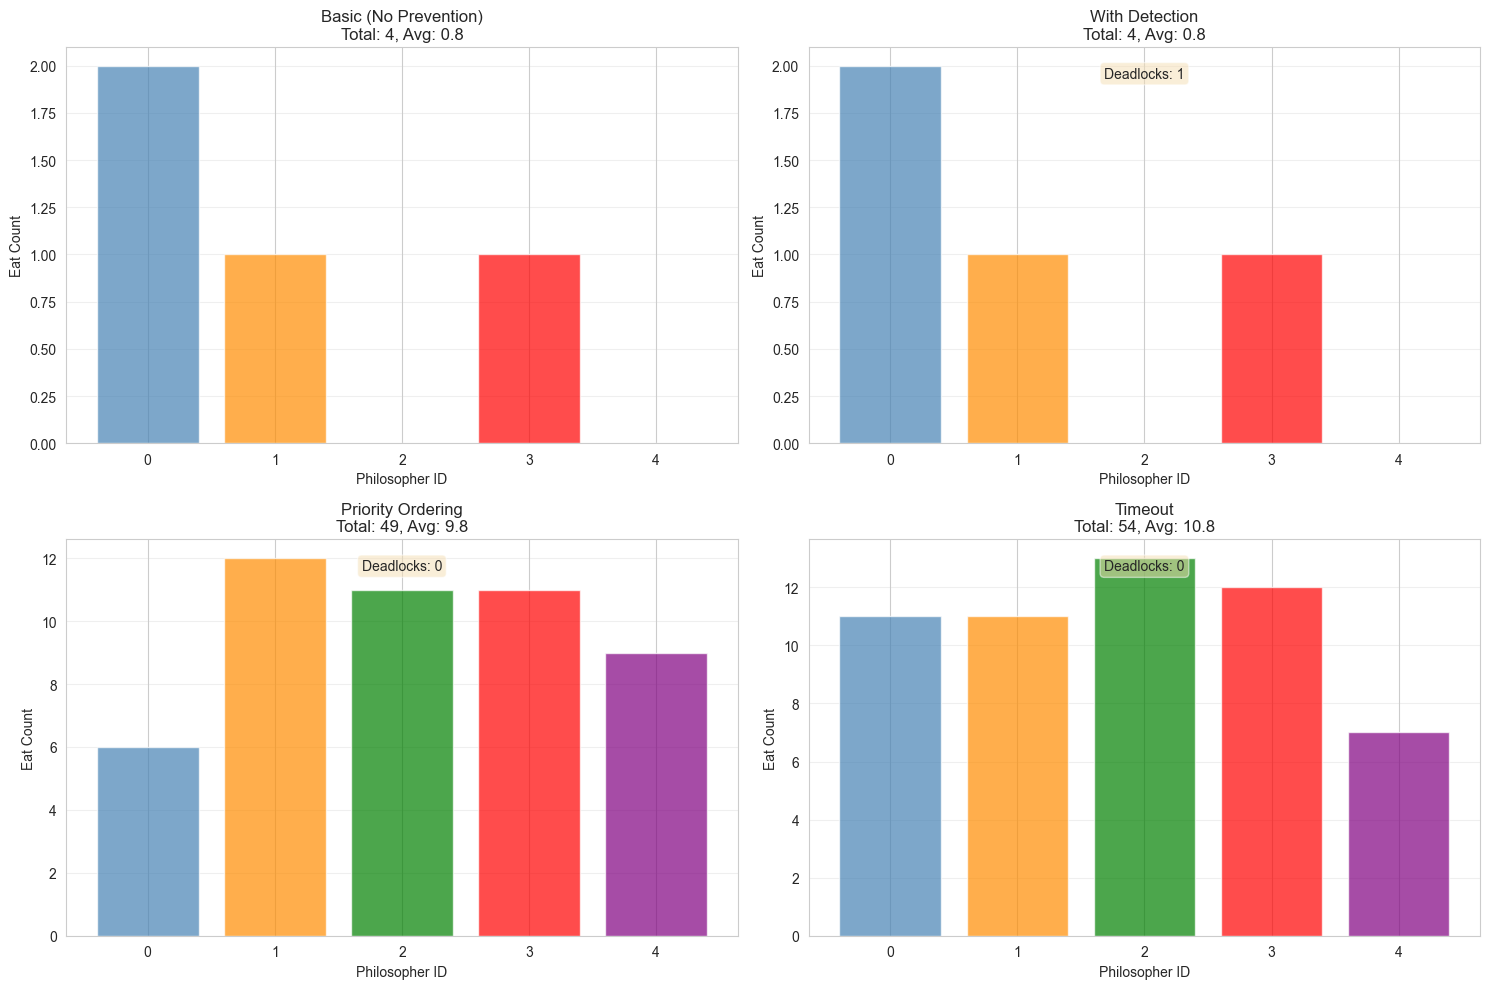

In [506]:
strategies = {
    'Basic (No Prevention)': sim1,
    'With Detection': sim2,
    'Priority Ordering': sim3a,
    'Timeout': sim3b
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, sim) in enumerate(strategies.items()):
    eat_counts = [p.eat_count for p in sim.philosophers]
    axes[idx].bar(range(5), eat_counts, color=['steelblue', 'darkorange', 'green', 'red', 'purple'], alpha=0.7)
    axes[idx].set_xlabel('Philosopher ID')
    axes[idx].set_ylabel('Eat Count')
    axes[idx].set_title(f'{name}\nTotal: {sum(eat_counts)}, Avg: {sum(eat_counts)/5:.1f}')
    axes[idx].set_xticks(range(5))
    axes[idx].grid(axis='y', alpha=0.3)
    
    # deadlock count
    if hasattr(sim, 'deadlock_count') and sim.deadlock_detection:
        axes[idx].text(0.5, 0.95, f'Deadlocks: {sim.deadlock_count}', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [507]:
summary_data = []
for name, sim in strategies.items():
    total_eats = sum(p.eat_count for p in sim.philosophers)
    avg_eats = total_eats / 5
    std_eats = np.std([p.eat_count for p in sim.philosophers])
    deadlocks = sim.deadlock_count if hasattr(sim, 'deadlock_count') else 'N/A'
    
    summary_data.append({
        'Strategy': name,
        'Total Eats': total_eats,
        'Avg Eats': f"{avg_eats:.2f}",
        'Std Dev': f"{std_eats:.2f}",
        'Deadlocks': deadlocks
    })

df_summary = pd.DataFrame(summary_data)
print("STRATEGY COMPARISON SUMMARY")
print(df_summary.to_string(index=False))

STRATEGY COMPARISON SUMMARY
             Strategy  Total Eats Avg Eats Std Dev  Deadlocks
Basic (No Prevention)           4     0.80    0.75          0
       With Detection           4     0.80    0.75          1
    Priority Ordering          49     9.80    2.14          0
              Timeout          54    10.80    2.04          0


## Left‑First vs Priority (Randomized vs Synchronized)

Compare left‑first (default) against lowest‑ID priority under both randomized and synchronized starts.


In [508]:
def run_compare(name, sim_kwargs, max_time=120.0, seed=123):
    random.seed(seed)
    np.random.seed(seed)
    sim = DiningPhilosophersSimulation(**sim_kwargs)
    sim.run(max_time=max_time)
    print(f'--- {name} ---')
    sim.print_statistics()
    return sim

# Left‑first (default: prevention_strategy='none')
lf_random = run_compare(
    'Left‑First / Randomized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=False),
    max_time=120.0, seed=101
)

lf_sync = run_compare(
    'Left‑First / Synchronized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=True, deadlock_prone=True, halt_on_deadlock=True),
    max_time=120.0, seed=102
)

# Priority (lowest‑ID first)
pr_random = run_compare(
    'Priority / Randomized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=False),
    max_time=120.0, seed=103
)

pr_sync = run_compare(
    'Priority / Synchronized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=True, deadlock_prone=True),
    max_time=120.0, seed=104
)


--- Left‑First / Randomized Start ---
Simulation Statistics (Time: 0 to 120.00)
Strategy: NONE

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            13           25.7            45.9            28.4           
1            10           30.1            33.6            36.4           
2            8            44.2            37.5            18.3           
3            14           41.3            39.5            19.2           
4            10           31.3            44.9            23.8           

Total Eats: 55
Average Eats per Philosopher: 11.00

Deadlocks Detected: 0
--- Left‑First / Synchronized Start ---
Simulation Statistics (Time: 0 to 0.00)
Strategy: NONE
Deadlock-prone timing: tighter think/eat times
Synchronized start: all hungry at t=0
*** SIMULATION HALTED DUE TO DEADLOCK ***

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            0            0.0             0.0             0.0            
1            0

# Task 4: Starvation Avoidance

Implementing a fairness mechanism so that all philosophers have a chance to eat.

Global Waiter: When a philosopher becomes hungry, put they are put in a queue. Only the philosopher at the front is allowed to try to acquire chopsticks. When they start eating, remove them from the queue.

In [509]:
# S4: Starvation Avoidance
random.seed(100)
np.random.seed(100)
sim4 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="priority",
    starvation_prevention=True,
    deadlock_prone=False,          # important for fairness
    synchronized_start=False,      # avoid forced crowding
)

sim4.run(max_time=120.0)
sim4.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: PRIORITY

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            8            30.6            37.8            31.6           
1            9            34.2            46.9            18.9           
2            9            36.8            40.5            22.7           
3            8            29.1            45.8            25.1           
4            7            42.2            36.5            21.3           

Total Eats: 41
Average Eats per Philosopher: 8.20

Deadlocks Detected: 0


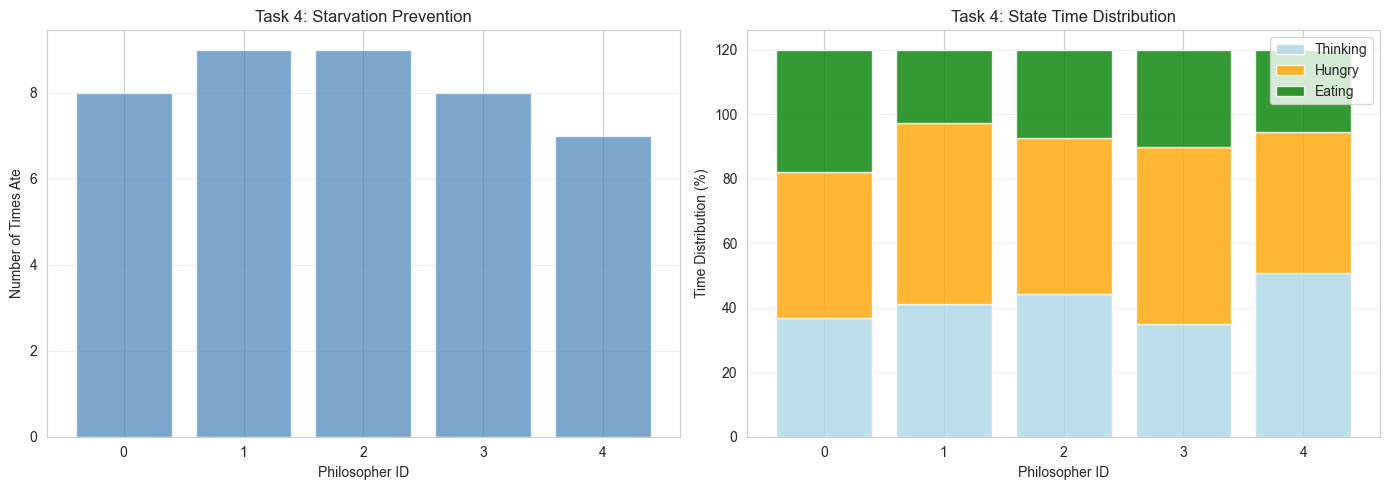

In [510]:
# task 4 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart of eat counts
eat_counts = [p.eat_count for p in sim4.philosophers]
axes[0].bar(range(5), eat_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Philosopher ID')
axes[0].set_ylabel('Number of Times Ate')
axes[0].set_title('Task 4: Starvation Prevention')
axes[0].set_xticks(range(5))
axes[0].grid(axis='y', alpha=0.3)

# bar chart of time distribution
thinking_pct = [p.total_thinking_time / 100 * 100 for p in sim4.philosophers]
hungry_pct = [p.total_hungry_time / 100 * 100 for p in sim4.philosophers]
eating_pct = [p.total_eating_time / 100 * 100 for p in sim4.philosophers]

x = np.arange(5)
axes[1].bar(x, thinking_pct, label='Thinking', color='lightblue', alpha=0.8)
axes[1].bar(x, hungry_pct, bottom=thinking_pct, label='Hungry', color='orange', alpha=0.8)
axes[1].bar(x, eating_pct, bottom=np.array(thinking_pct) + np.array(hungry_pct), label='Eating', color='green', alpha=0.8)
axes[1].set_xlabel('Philosopher ID')
axes[1].set_ylabel('Time Distribution (%)')
axes[1].set_title('Task 4: State Time Distribution')
axes[1].set_xticks(range(5))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [511]:
def compute_statistics(sim):
    eat_counts = np.array([p.eat_count for p in sim.philosophers])
    hungry_times = np.array([p.total_hungry_time for p in sim.philosophers])
    eating_times = np.array([p.total_eating_time for p in sim.philosophers])

    stats = {
        "total_time": sim.current_time,
        "total_eats": eat_counts.sum(),
        "avg_eats": eat_counts.mean(),
        "eat_std": eat_counts.std(),
        "min_eats": eat_counts.min(),
        "max_eats": eat_counts.max(),

        "avg_hungry_time": hungry_times.mean(),
        "max_hungry_time": hungry_times.max(),

        "avg_eating_time": eating_times.mean(),

        "throughput": eat_counts.sum() / sim.current_time if sim.current_time > 0 else 0
    }

    return stats


def print_statistics(stats, title="Simulation Statistics"):
    print(f"\n{title}")
    print("-" * len(title))

    print(f"Total simulation time      : {stats['total_time']:.2f}")
    print(f"Total eats                 : {stats['total_eats']}")
    print(f"Average eats               : {stats['avg_eats']:.2f}")
    print(f"Eat count std deviation    : {stats['eat_std']:.2f}")
    print(f"Min / Max eats             : {stats['min_eats']} / {stats['max_eats']}")
    print()
    print(f"Average hungry time        : {stats['avg_hungry_time']:.2f}")
    print(f"Maximum hungry time        : {stats['max_hungry_time']:.2f}")
    print(f"Average eating time        : {stats['avg_eating_time']:.2f}")
    print()
    print(f"Throughput (eats / time)   : {stats['throughput']:.3f}")

stats_no_prevention = compute_statistics(sim3a)
stats_with_prevention = compute_statistics(sim4)

print_statistics(stats_no_prevention, "Without Starvation Prevention")
print_statistics(stats_with_prevention, "With Starvation Prevention")



Without Starvation Prevention
-----------------------------
Total simulation time      : 120.00
Total eats                 : 49
Average eats               : 9.80
Eat count std deviation    : 2.14
Min / Max eats             : 6 / 12

Average hungry time        : 34.79
Maximum hungry time        : 47.43
Average eating time        : 30.03

Throughput (eats / time)   : 0.408

With Starvation Prevention
--------------------------
Total simulation time      : 120.00
Total eats                 : 41
Average eats               : 8.20
Eat count std deviation    : 0.75
Min / Max eats             : 7 / 9

Average hungry time        : 49.82
Maximum hungry time        : 56.33
Average eating time        : 28.68

Throughput (eats / time)   : 0.342


## Monte Carlo Check (Tasks 1–4)

Run multiple simulations with different seeds to estimate averages, deadlock probability, and fairness.


In [512]:
def run_monte_carlo(sim_kwargs, runs=50, max_time=100.0, base_seed=1000):
    results = []
    for i in range(runs):
        seed = base_seed + i
        random.seed(seed)
        np.random.seed(seed)
        sim = DiningPhilosophersSimulation(**sim_kwargs)
        sim.run(max_time=max_time)
        eat_counts = [p.eat_count for p in sim.philosophers]
        results.append({
            'seed': seed,
            'total_eats': sum(eat_counts),
            'avg_eats': np.mean(eat_counts),
            'std_eats': float(np.std(eat_counts)),
            'min_eats': min(eat_counts),
            'max_eats': max(eat_counts),
            'deadlocks': sim.deadlock_count,
            'halted': sim.halted,
            'eat_counts': eat_counts,
        })
    return pd.DataFrame(results)

mc_basic = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy='none'),
    runs=50, max_time=120.0, base_seed=1000
)

mc_detect = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', halt_on_deadlock=True),
    runs=50, max_time=120.0, base_seed=1000
)

mc_priority = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority'),
    runs=50, max_time=120.0, base_seed=3000
)

mc_timeout = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='timeout', timeout_duration=2.0),
    runs=50, max_time=120.0, base_seed=4000
)

mc_basic_fifo = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=5000
)

mc_priority_fifo = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=6000
)

mc_timeout_fifo = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=7000
)


def summarize_mc(df, name):
    print(f'=== {name} ===')
    print(f'Runs: {len(df)}')
    print(f'Avg total eats: {df.total_eats.mean():.2f} ± {df.total_eats.std():.2f}')
    print(f'Avg eats/philosopher: {df.avg_eats.mean():.2f} ± {df.avg_eats.std():.2f}')
    print(f'Avg std (fairness): {df.std_eats.mean():.2f}')
    deadlock_runs = (df.deadlocks > 0).sum()
    print(f'Deadlock runs: {deadlock_runs}/{len(df)}')
    print()

summarize_mc(mc_basic, "Basic (No Prevention)")
summarize_mc(mc_basic_fifo, "Basic + FIFO Starvation Prevention")
summarize_mc(mc_detect, "Detection (Synchronized)")
summarize_mc(mc_priority, "Priority Ordering")
summarize_mc(mc_priority_fifo, "Priority + FIFO Starvation Prevention")
summarize_mc(mc_timeout, "Timeout")
summarize_mc(mc_timeout_fifo, "Timeout + FIFO Starvation Prevention")


=== Basic (No Prevention) ===
Runs: 50
Avg total eats: 45.78 ± 8.33
Avg eats/philosopher: 9.16 ± 1.67
Avg std (fairness): 1.54
Deadlock runs: 0/50

=== Basic + FIFO Starvation Prevention ===
Runs: 50
Avg total eats: 18.72 ± 18.69
Avg eats/philosopher: 3.74 ± 3.74
Avg std (fairness): 0.77
Deadlock runs: 0/50

=== Detection (Synchronized) ===
Runs: 50
Avg total eats: 45.78 ± 8.33
Avg eats/philosopher: 9.16 ± 1.67
Avg std (fairness): 1.54
Deadlock runs: 6/50

=== Priority Ordering ===
Runs: 50
Avg total eats: 52.52 ± 6.21
Avg eats/philosopher: 10.50 ± 1.24
Avg std (fairness): 1.85
Deadlock runs: 0/50

=== Priority + FIFO Starvation Prevention ===
Runs: 50
Avg total eats: 21.42 ± 16.64
Avg eats/philosopher: 4.28 ± 3.33
Avg std (fairness): 0.79
Deadlock runs: 0/50

=== Timeout ===
Runs: 50
Avg total eats: 51.84 ± 4.33
Avg eats/philosopher: 10.37 ± 0.87
Avg std (fairness): 1.72
Deadlock runs: 1/50

=== Timeout + FIFO Starvation Prevention ===
Runs: 50
Avg total eats: 30.74 ± 18.66
Avg eats/p

remove this part: === Basic + FIFO Starvation Prevention === \
use only randomized stats

do the bar plots with mean and std

In [513]:
    
def gini_coefficient(x):
    x = np.array(x, dtype=float)
    if np.allclose(x, 0):
        return 0.0
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def run_monte_carlo_detailed(sim_kwargs, runs=50, max_time=100.0, base_seed=5000):
    results = []
    for i in range(runs):
        seed = base_seed + i
        random.seed(seed)
        np.random.seed(seed)

        sim = DiningPhilosophersSimulation(**sim_kwargs)
        sim.run(max_time=max_time)

        eat_counts = [p.eat_count for p in sim.philosophers]
        hungry_times = [p.total_hungry_time for p in sim.philosophers]
        eating_times = [p.total_eating_time for p in sim.philosophers]
        thinking_times = [p.total_thinking_time for p in sim.philosophers]

        row = {
            "seed": seed,
            "total_eats": int(sum(eat_counts)),
            "avg_eats": float(np.mean(eat_counts)),
            "std_eats": float(np.std(eat_counts)),
            "min_eats": int(min(eat_counts)),
            "max_eats": int(max(eat_counts)),
            "gini_eats": float(gini_coefficient(eat_counts)),
            "deadlocks": int(sim.deadlock_count),
            "first_deadlock_time": (min(sim.deadlock_times) if sim.deadlock_times else None),
            "eat_counts": eat_counts,
            "hungry_times": hungry_times,
            "eating_times": eating_times,
            "thinking_times": thinking_times,
            # "timeout_releases": int(sim.timeout_release_count),
        }

        strategy = sim_kwargs.get("prevention_strategy")

        if strategy == "timeout":
            row["timeout_releases"] = int(sim.timeout_release_count)

        if strategy in {"timeout", "priority"}:
            row["persistent_deadlocks"] = int(getattr(sim, "persistent_deadlock_count", 0))
            row["first_persistent_deadlock_time"] = (
                min(getattr(sim, "persistent_deadlock_times", []))
                if getattr(sim, "persistent_deadlock_times", [])
                else None
            )


        results.append(row)

    return pd.DataFrame(results)

def summarize_detailed(df, name):
    print(f"=== {name} (Detailed) ===")
    print(f"Runs: {len(df)}")
    print(f"Avg total eats: {df.total_eats.mean():.2f} ± {df.total_eats.std():.2f}")
    print(f"Avg eats/philosopher: {df.avg_eats.mean():.2f} ± {df.avg_eats.std():.2f}")
    print(f"Avg min/max eats: {df.min_eats.mean():.2f} / {df.max_eats.mean():.2f}")
    print(f"Avg Gini (fairness): {df.gini_eats.mean():.3f}")
    deadlock_runs = (df.deadlocks > 0).sum()
    print(f"Deadlock runs: {deadlock_runs}/{len(df)}")
    if deadlock_runs > 0:
        first_times = df.loc[df.deadlocks > 0, "first_deadlock_time"].dropna()
        if len(first_times) > 0:
            print(f"Avg first deadlock time: {first_times.mean():.2f}")

    # Timeout releases nur wenn Spalte existiert (oder strategy timeout)
    if "timeout_releases" in df.columns:
        print(f"Avg timeout releases/run: {df.timeout_releases.mean():.2f} ± {df.timeout_releases.std():.2f}")

    # Persistent deadlocks nur für timeout/priority (d.h. nur wenn Spalte existiert)
    if "persistent_deadlocks" in df.columns:
        p_runs = (df.persistent_deadlocks > 0).sum()
        print(f"Persistent-deadlock runs: {p_runs}/{len(df)}")
        if p_runs > 0 and "first_persistent_deadlock_time" in df.columns:
            p_first = df.loc[df.persistent_deadlocks > 0, "first_persistent_deadlock_time"].dropna()
            if len(p_first) > 0:
                print(f"Avg first persistent deadlock time: {p_first.mean():.2f}")

    # optional: how many runs had at least one timeout release
    # tr_runs = (df.timeout_releases > 0).sum()
    # print(f"Runs with ≥1 timeout release: {tr_runs}/{len(df)}")

    eats = np.array(df.eat_counts.to_list())
    print("Per-philosopher avg eats:", np.round(eats.mean(axis=0), 2).tolist())
    print("Per-philosopher std eats:", np.round(eats.std(axis=0), 2).tolist())

    # per-philosopher mean state times (over runs) 
    hungry = np.array(df.hungry_times.to_list())    # shape: (runs, num_phils)
    eating = np.array(df.eating_times.to_list())
    thinking = np.array(df.thinking_times.to_list())

    print("Per-philosopher avg thinking time:", np.round(thinking.mean(axis=0), 2).tolist())
    print("Per-philosopher avg hungry time:  ", np.round(hungry.mean(axis=0), 2).tolist())
    print("Per-philosopher avg eating time:  ", np.round(eating.mean(axis=0), 2).tolist())

    print("Per-philosopher std thinking time:", np.round(thinking.std(axis=0), 2).tolist())
    print("Per-philosopher std hungry time:  ", np.round(hungry.std(axis=0), 2).tolist())
    print("Per-philosopher std eating time:  ", np.round(eating.std(axis=0), 2).tolist())


    zero_eat_rate = (eats == 0).mean(axis=0)
    print("Zero-eat rate by philosopher:", np.round(zero_eat_rate, 3).tolist())
    print()


# No starvation prevention
mc_basic_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=False),
    runs=50, max_time=120.0, base_seed=5000
)

mc_detect_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="none", halt_on_deadlock=True),
    runs=50, max_time=120.0, base_seed=5000
)

mc_priority_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=False),
    runs=50, max_time=120.0, base_seed=7000
)

mc_timeout_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=False),
    runs=50, max_time=120.0, base_seed=8000
)

# With starvation prevention (FIFO)
mc_basic_fifo_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=9000
)

mc_priority_fifo_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=10000
)

mc_timeout_fifo_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=11000
)

summarize_detailed(mc_basic_d, "Basic (No Prevention)")
summarize_detailed(mc_basic_fifo_d, "Basic + FIFO Starvation Prevention")
summarize_detailed(mc_detect_d, "Detection (Synchronized)")
summarize_detailed(mc_priority_d, "Priority Ordering")
summarize_detailed(mc_priority_fifo_d, "Priority + FIFO Starvation Prevention")
summarize_detailed(mc_timeout_d, "Timeout")
summarize_detailed(mc_timeout_fifo_d, "Timeout + FIFO Starvation Prevention")
     

=== Basic (No Prevention) (Detailed) ===
Runs: 50
Avg total eats: 45.86 ± 9.92
Avg eats/philosopher: 9.17 ± 1.98
Avg min/max eats: 7.14 / 11.20
Avg Gini (fairness): 0.090
Deadlock runs: 0/50
Per-philosopher avg eats: [9.32, 9.08, 9.3, 9.28, 8.88]
Per-philosopher std eats: [2.8, 2.59, 2.59, 2.31, 2.31]
Per-philosopher avg thinking time: [48.67, 47.56, 46.18, 46.4, 48.9]
Per-philosopher avg hungry time:   [44.46, 46.33, 47.63, 44.31, 44.91]
Per-philosopher avg eating time:   [26.86, 26.11, 26.19, 29.29, 26.19]
Per-philosopher std thinking time: [15.15, 16.33, 11.84, 15.64, 17.16]
Per-philosopher std hungry time:   [18.75, 17.19, 17.02, 19.04, 17.97]
Per-philosopher std eating time:   [10.59, 9.87, 9.34, 10.39, 9.17]
Zero-eat rate by philosopher: [0.02, 0.0, 0.0, 0.0, 0.0]

=== Basic + FIFO Starvation Prevention (Detailed) ===
Runs: 50
Avg total eats: 20.66 ± 18.55
Avg eats/philosopher: 4.13 ± 3.71
Avg min/max eats: 3.20 / 5.10
Avg Gini (fairness): 0.186
Deadlock runs: 0/50
Per-philosophe

### Monte Carlo for 4-Case Comparison

In [514]:
mc_lf_random = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=False),
    runs=100, max_time=120.0, base_seed=9000
)

mc_lf_sync = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=True, deadlock_prone=True, halt_on_deadlock=True),
    runs=100, max_time=120.0, base_seed=9100
)

mc_pr_random = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=False),
    runs=100, max_time=120.0, base_seed=9200
)

mc_pr_sync = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=True, deadlock_prone=True),
    runs=100, max_time=120.0, base_seed=9300
)

summarize_detailed(mc_lf_random, 'Left-First / Randomized (MC)')
# summarize_detailed(mc_lf_sync, 'Left-First / Synchronized (MC)')
summarize_detailed(mc_pr_random, 'Priority / Randomized (MC)')
# summarize_detailed(mc_pr_sync, 'Priority / Synchronized (MC)')


=== Left-First / Randomized (MC) (Detailed) ===
Runs: 100
Avg total eats: 47.96 ± 6.62
Avg eats/philosopher: 9.59 ± 1.32
Avg min/max eats: 7.51 / 11.79
Avg Gini (fairness): 0.088
Deadlock runs: 17/100
Avg first deadlock time: 76.99
Per-philosopher avg eats: [9.34, 9.54, 9.61, 9.75, 9.72]
Per-philosopher std eats: [2.11, 2.35, 2.04, 2.14, 1.91]
Per-philosopher avg thinking time: [49.74, 48.37, 48.97, 50.78, 49.28]
Per-philosopher avg hungry time:   [43.5, 43.47, 41.51, 41.06, 43.68]
Per-philosopher avg eating time:   [26.76, 28.16, 29.53, 28.16, 27.04]
Per-philosopher std thinking time: [12.37, 11.51, 12.69, 11.14, 12.09]
Per-philosopher std hungry time:   [11.61, 12.65, 12.81, 12.0, 11.4]
Per-philosopher std eating time:   [7.54, 8.03, 8.26, 8.34, 7.52]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Priority / Randomized (MC) (Detailed) ===
Runs: 100
Avg total eats: 50.87 ± 6.28
Avg eats/philosopher: 10.17 ± 1.26
Avg min/max eats: 7.89 / 12.81
Avg Gini (fairness): 0.095
D

# Task 5

General settings:

- simulation will be run for 800 time units (= mins), since we will vary the thinking / eating times + increase number of philosophers

- this task will be based on the simulation engine including the deadlock prevention rules (= solution to task 3)

## Helper Functions for multiple runs

In [515]:
# ---- 2) Helper: merge dicts (later dicts override earlier ones) ----
def merge_cfg(*parts):
    cfg = {}
    for p in parts:
        cfg.update(p)
    return cfg

# ---- 3) Helper: auto label from cfg ----
def cfg_label(cfg, title_prefix=""):
    # strategy
    s = cfg.get("prevention_strategy", "none")
    if s == "none":
        strat = "Left-First"
    elif s == "priority":
        strat = "Priority"
    elif s == "timeout":
        strat = f"Timeout(t={cfg.get('timeout_duration', '?')})"
    else:
        strat = s

    # thinking
    if cfg.get("unif_thinking_time", False):
        think = f"Think U({cfg.get('think_unif_low')},{cfg.get('think_unif_high')})"
    else:
        think = "Think Exp(mean=5)"  # your default

    # eating
    if cfg.get("gauss_eating_time", False):
        eat = f"Eat N({cfg.get('eat_mean')},{cfg.get('eat_sigma')}) truncated[{cfg.get('eat_gauss_low')},{cfg.get('eat_gauss_high')}]"
    else:
        eat = "Eat Exp(mean=3)"  # your default

    prefix = (title_prefix + " - ") if title_prefix else ""
    return f"{prefix}{strat} - {think} - {eat}"

# ---- 4) One runner for MC + summary ----
def run_and_summarize(cfg, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix=""):
    df = run_monte_carlo_detailed(cfg, runs=runs, max_time=max_time, base_seed=base_seed)
    summarize_detailed(df, cfg_label(cfg, title_prefix=title_prefix))
    return df

## Inreasing number of philosophers and chopsticks

In [516]:
MAX_TIME = 800
MC_RUNS = 50
NUM_PHILS = 10
SEED = 9000
TIMEOUT_DURATION = 1

BASE = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
)

STRATEGY = {
    "left_first": dict(prevention_strategy="none"),
    "priority": dict(prevention_strategy="priority"),
    "timeout": dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION),
}

In [517]:
MAX_TIME = 800
MC_RUNS = 50
NUM_PHILS = 10
SEED = 9000
TIMEOUT_DURATION = 1

BASE = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
    halt_on_deadlock=True
)

# Left-first
mc_lf_random_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none")),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Priority
mc_pr_random_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority")),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Timeout
mc_timeout_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)


=== Randomized (MC) - Left-First - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 50
Avg total eats: 529.20 ± 152.64
Avg eats/philosopher: 52.92 ± 15.26
Avg min/max eats: 46.28 / 60.38
Avg Gini (fairness): 0.054
Deadlock runs: 11/50
Avg first deadlock time: 455.17
Per-philosopher avg eats: [52.5, 54.06, 51.38, 53.64, 52.9, 53.18, 53.68, 51.98, 53.18, 52.7]
Per-philosopher std eats: [15.64, 15.71, 15.27, 15.87, 15.85, 16.13, 15.95, 15.35, 15.73, 15.96]
Per-philosopher avg thinking time: [270.81, 270.58, 273.16, 267.56, 268.34, 271.43, 270.77, 272.76, 268.15, 266.85]
Per-philosopher avg hungry time:   [297.48, 295.84, 294.52, 300.29, 295.25, 298.58, 295.85, 296.61, 297.04, 291.67]
Per-philosopher avg eating time:   [155.84, 157.72, 156.46, 156.3, 160.55, 154.13, 157.52, 154.76, 158.95, 165.62]
Per-philosopher std thinking time: [81.9, 84.2, 84.83, 82.84, 79.51, 80.14, 81.84, 84.15, 83.11, 82.08]
Per-philosopher std hungry time:   [82.01, 83.98, 80.29, 85.66, 80.87, 82.2, 80.0, 

I just see 0 deadlocks in the timeout case. i want to look at that in more detail:

In [518]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(num_philosophers=NUM_PHILS, deadlock_detection=True, halt_on_deadlock= True)

mc_timeout_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)



=== Randomized (MC) - Timeout(t=2) - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 355.02 ± 14.78
Avg eats/philosopher: 71.00 ± 2.96
Avg min/max eats: 64.98 / 77.34
Avg Gini (fairness): 0.034
Deadlock runs: 12/100
Avg first deadlock time: 394.74
Avg timeout releases/run: 159.60 ± 17.77
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [70.93, 71.11, 71.2, 71.06, 70.72]
Per-philosopher std eats: [5.28, 6.2, 5.71, 5.55, 5.46]
Per-philosopher avg thinking time: [356.16, 361.68, 360.78, 355.6, 354.72]
Per-philosopher avg hungry time:   [226.16, 230.53, 229.3, 227.92, 236.13]
Per-philosopher avg eating time:   [217.68, 207.79, 209.92, 216.48, 209.15]
Per-philosopher std thinking time: [29.41, 33.98, 33.2, 34.82, 34.28]
Per-philosopher std hungry time:   [28.88, 35.4, 31.18, 31.27, 30.82]
Per-philosopher std eating time:   [24.98, 22.7, 25.59, 21.67, 22.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



so we see that with the same settings just with num_phils = 5, we apparently got deadlocks. 

So maybe the explanation is that with 10 philosophers, getting into a deadlock is much more unlikely than for 5 philosophers? 

Let's try it with less than 5 philosophers:

In [519]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 3
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(num_philosophers=NUM_PHILS, deadlock_detection=True)

mc_timeout_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)



=== Randomized (MC) - Timeout(t=2) - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 211.80 ± 10.54
Avg eats/philosopher: 70.60 ± 3.51
Avg min/max eats: 66.33 / 74.98
Avg Gini (fairness): 0.027
Deadlock runs: 93/100
Avg first deadlock time: 225.64
Avg timeout releases/run: 114.04 ± 14.47
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [70.82, 70.77, 70.21]
Per-philosopher std eats: [5.32, 4.85, 5.95]
Per-philosopher avg thinking time: [355.84, 356.8, 360.01]
Per-philosopher avg hungry time:   [231.93, 234.86, 234.56]
Per-philosopher avg eating time:   [212.23, 208.34, 205.42]
Per-philosopher std thinking time: [33.3, 26.97, 30.95]
Per-philosopher std hungry time:   [29.08, 24.52, 27.9]
Per-philosopher std eating time:   [24.21, 23.22, 21.49]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0]



Okay so with 3 phils, we see that we got a lot more deadlocks. So, it apparently is much more likely in this case that we have the deadlock conditions to get true

So I think for this reason, I will rather look at 5 philosophers, to ensure that deadlock chances are higher

## Variability in thinking time

In [520]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(num_philosophers=NUM_PHILS, deadlock_detection=True)

THINK_2_30 = dict(unif_thinking_time=True, think_unif_low=2.0, think_unif_high=30.0)
THINK_2_4  = dict(unif_thinking_time=True, think_unif_low=2.0, think_unif_high=4.0)

# Left-first, think U(2,30)
mc_lf_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none"), THINK_2_30),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Priority, think U(2,30)
mc_lf_5_4 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority"), THINK_2_30),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Left-first, think U(2,4)
mc_lf_5_2 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none"), THINK_2_4),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Priority, think U(2,4)
mc_lf_5_3 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority"), THINK_2_4),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

=== Randomized (MC) - Left-First - Think U(2.0,30.0) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 194.42 ± 7.29
Avg eats/philosopher: 38.88 ± 1.46
Avg min/max eats: 35.93 / 41.97
Avg Gini (fairness): 0.030
Deadlock runs: 0/100
Per-philosopher avg eats: [38.83, 38.84, 39.03, 38.91, 38.81]
Per-philosopher std eats: [2.55, 2.86, 3.07, 2.9, 2.49]
Per-philosopher avg thinking time: [621.28, 621.07, 619.15, 621.9, 621.77]
Per-philosopher avg hungry time:   [61.82, 62.59, 63.31, 60.17, 63.67]
Per-philosopher avg eating time:   [116.91, 116.33, 117.54, 117.94, 114.56]
Per-philosopher std thinking time: [22.95, 23.64, 24.56, 24.51, 24.56]
Per-philosopher std hungry time:   [16.61, 18.12, 18.66, 16.47, 18.02]
Per-philosopher std eating time:   [18.83, 18.15, 17.87, 18.68, 15.06]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Randomized (MC) - Priority - Think U(2.0,30.0) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 193.66 ± 7.56
Avg eats/philosopher: 38.

we see the impact of the thinking time. if the thinking time duration is higher, then the deadlock chances are lower. i will also change the distribution for the eating times.

we also see here, the inequality in the priority increases with the number of philosophers / changing times

## Variability in eating time

Conclusion:

Setting thinking_time~unif(2,4) is just too much time for thinking. in this case, we have nearly 0 deadlock cases, so not that interesting. 

For this reason, I set thinking_time~unif(0.3,3), eating_time i will maybe alternate.

In [521]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
)

THINKING = {
    "unif_2_30": dict(unif_thinking_time=True, think_unif_low=2.0, think_unif_high=30.0),
    "unif_0_3_3": dict(unif_thinking_time=True, think_unif_low=0.3, think_unif_high=3.0),
}

EATING = {
    "gauss_8_3_1_16": dict(gauss_eating_time=True, eat_mean=8.0, eat_sigma=3.0, eat_gauss_low=1.0, eat_gauss_high=16.0),
    "gauss_15_3_1_30": dict(gauss_eating_time=True, eat_mean=15.0, eat_sigma=3.0, eat_gauss_low=1.0, eat_gauss_high=30.0),
}

STRATEGY = {
    "left_first": dict(prevention_strategy="none"),
    "priority": dict(prevention_strategy="priority"),
    "timeout": dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION),
}

# looking at gauss_8_3_1_16 

mc3 = run_and_summarize(merge_cfg(BASE, STRATEGY["left_first"], THINKING["unif_0_3_3"], EATING["gauss_8_3_1_16"]))
mc4 = run_and_summarize(merge_cfg(BASE, STRATEGY["priority"],   THINKING["unif_0_3_3"], EATING["gauss_8_3_1_16"]))
TIMEOUT_DURATION = 8
STRATEGY["timeout"] = dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)
mc5 = run_and_summarize(merge_cfg(BASE, STRATEGY["timeout"],   THINKING["unif_0_3_3"], EATING["gauss_8_3_1_16"]))

# looking at gauss_15_3_1_30

mc3 = run_and_summarize(merge_cfg(BASE, STRATEGY["left_first"], THINKING["unif_0_3_3"], EATING["gauss_15_3_1_30"]))
mc4 = run_and_summarize(merge_cfg(BASE, STRATEGY["priority"],   THINKING["unif_0_3_3"], EATING["gauss_15_3_1_30"]))
TIMEOUT_DURATION = 15
STRATEGY["timeout"] = dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)
mc5 = run_and_summarize(merge_cfg(BASE, STRATEGY["timeout"],   THINKING["unif_0_3_3"], EATING["gauss_15_3_1_30"]))


=== Left-First - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 99.48 ± 4.09
Avg eats/philosopher: 19.90 ± 0.82
Avg min/max eats: 19.37 / 20.38
Avg Gini (fairness): 0.010
Deadlock runs: 36/100
Avg first deadlock time: 377.01
Per-philosopher avg eats: [19.98, 19.82, 19.82, 19.92, 19.94]
Per-philosopher std eats: [0.95, 0.88, 0.92, 0.95, 0.98]
Per-philosopher avg thinking time: [34.48, 34.03, 33.7, 34.44, 34.43]
Per-philosopher avg hungry time:   [606.67, 607.08, 609.44, 605.18, 604.92]
Per-philosopher avg eating time:   [158.85, 158.9, 156.87, 160.39, 160.65]
Per-philosopher std thinking time: [3.64, 3.73, 4.0, 3.61, 4.04]
Per-philosopher std hungry time:   [12.15, 13.67, 15.15, 11.77, 14.35]
Per-philosopher std eating time:   [11.63, 13.56, 13.38, 10.76, 13.33]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72

the results seem legit, except for the thing with the deadlocks with the timeout strategy: gpt says, normyll with the timeout stratefy, we expect 0 deadlocks, but maybe it is beacuse of our implementation, where the deadlock just occurs for a short while, and then gets solved by the timeout strategy, but is still counted. 

## Selfish Philosophers

- Ideas for Selfish philosophers:
    - Ignores timeout and still holds chopsticks
    - Ignores priority ordering -> just takes left or right chopstick first randomly
    - Does not drop chopsticks directly after eating

I will just use the following base configs of the model:

- 5 Philosophers, Max_time = 800, MC runs = 100
- thinking time: unif(0.3, 3)
- eating time: norm(8, 3) (truncated: [1, 16]) 
- prevention strategy: lower chopstick id or timeout, will depend on actual case (f.e. ignoring timeout just possible for timeout strategy)

### Baseline for lower chopstick id strategy

In [522]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000

BASE_COMMON = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
    halt_on_deadlock = True,

    # thinking: U(0.3, 3)
    unif_thinking_time=True,
    think_unif_low=0.3,
    think_unif_high=3.0,

    # eating: N(8,3) truncated to [1,16]
    gauss_eating_time=True,
    eat_mean=8.0,
    eat_sigma=3.0,
    eat_gauss_low=1.0,
    eat_gauss_high=16.0,
)

# Baseline 1: Priority (lower ID first)
cfg_priority = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="priority")
)
df_priority = run_and_summarize(cfg_priority, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")


=== Baseline - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72
Avg eats/philosopher: 35.16 ± 0.94
Avg min/max eats: 29.17 / 45.66
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [29.46, 33.61, 37.47, 45.66, 29.6]
Per-philosopher std eats: [1.75, 1.34, 1.47, 2.51, 1.67]
Per-philosopher avg thinking time: [49.92, 56.12, 62.89, 76.11, 50.15]
Per-philosopher avg hungry time:   [515.05, 474.82, 435.67, 359.34, 510.37]
Per-philosopher avg eating time:   [235.02, 269.05, 301.45, 364.55, 239.49]
Per-philosopher std thinking time: [5.5, 4.53, 5.2, 6.08, 5.35]
Per-philosopher std hungry time:   [20.17, 17.77, 19.5, 19.49, 21.8]
Per-philosopher std eating time:   [17.31, 16.44, 17.8, 18.04, 19.59]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



### Baseline for timeout strategy

In [523]:
TIMEOUT_DURATION = 8  # aligned with eat_mean=8

# Baseline 2: Timeout
cfg_timeout = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)
)
df_timeout = run_and_summarize(cfg_timeout, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

=== Baseline - Timeout(t=8) - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 160.24 ± 6.62
Avg eats/philosopher: 32.05 ± 1.32
Avg min/max eats: 29.29 / 34.76
Avg Gini (fairness): 0.034
Deadlock runs: 17/100
Avg first deadlock time: 397.93
Avg timeout releases/run: 80.67 ± 9.41
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.03, 31.94, 32.11, 31.88, 32.28]
Per-philosopher std eats: [2.33, 2.5, 2.61, 2.47, 2.69]
Per-philosopher avg thinking time: [53.75, 54.27, 54.29, 52.86, 53.92]
Per-philosopher avg hungry time:   [490.21, 491.34, 485.71, 494.37, 485.32]
Per-philosopher avg eating time:   [256.04, 254.4, 260.0, 252.77, 260.76]
Per-philosopher std thinking time: [5.97, 6.42, 6.01, 6.17, 6.36]
Per-philosopher std hungry time:   [25.49, 26.13, 24.5, 25.6, 28.94]
Per-philosopher std eating time:   [22.12, 22.67, 21.62, 22.34, 24.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



### 1 Selfish Philosopher: Ignoring timeout + Not dropping after eating

Selfish Philosopher does the following:
- Ignores timeout and still holds chopsticks
- Does not drop chopsticks directly after eating

In [530]:
TIMEOUT_DURATION = 8 

# Again printing timeout baseline results:
df_timeout = run_and_summarize(cfg_timeout, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# 1 selfish philosopher 
cfg_selfish_1 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="timeout",
        timeout_duration=TIMEOUT_DURATION,
        selfish_ids={3},            
    )
)

df_selfish_1 = run_and_summarize(cfg_selfish_1, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="1 Selfish Philosopher")

=== Baseline - Timeout(t=8) - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 160.24 ± 6.62
Avg eats/philosopher: 32.05 ± 1.32
Avg min/max eats: 29.29 / 34.76
Avg Gini (fairness): 0.034
Deadlock runs: 17/100
Avg first deadlock time: 397.93
Avg timeout releases/run: 80.67 ± 9.41
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.03, 31.94, 32.11, 31.88, 32.28]
Per-philosopher std eats: [2.33, 2.5, 2.61, 2.47, 2.69]
Per-philosopher avg thinking time: [53.75, 54.27, 54.29, 52.86, 53.92]
Per-philosopher avg hungry time:   [490.21, 491.34, 485.71, 494.37, 485.32]
Per-philosopher avg eating time:   [256.04, 254.4, 260.0, 252.77, 260.76]
Per-philosopher std thinking time: [5.97, 6.42, 6.01, 6.17, 6.36]
Per-philosopher std hungry time:   [25.49, 26.13, 24.5, 25.6, 28.94]
Per-philosopher std eating time:   [22.12, 22.67, 21.62, 22.34, 24.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== 1 Selfish Philosopher - Timeout(t=8)

nice, we see that the selfish philosoper 3 had the most eatings + philosoper 2 just got the lowest number of eats. that's good for analysis

### 2 Selfish Philosophers: Ignoring timeout + Not dropping after eating

They do the same as in the case with 1 selfish philoopher

In [531]:
TIMEOUT_DURATION = 8 

# Again printing timeout baseline results:
df_timeout = run_and_summarize(cfg_timeout, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# 2 selfish philosophers 
cfg_selfish_2 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="timeout",
        timeout_duration=TIMEOUT_DURATION,
        selfish_ids={0,2},            
    )
)

df_selfish_2 = run_and_summarize(cfg_selfish_2, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="2 Selfish Philosophers")

=== Baseline - Timeout(t=8) - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 160.24 ± 6.62
Avg eats/philosopher: 32.05 ± 1.32
Avg min/max eats: 29.29 / 34.76
Avg Gini (fairness): 0.034
Deadlock runs: 17/100
Avg first deadlock time: 397.93
Avg timeout releases/run: 80.67 ± 9.41
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.03, 31.94, 32.11, 31.88, 32.28]
Per-philosopher std eats: [2.33, 2.5, 2.61, 2.47, 2.69]
Per-philosopher avg thinking time: [53.75, 54.27, 54.29, 52.86, 53.92]
Per-philosopher avg hungry time:   [490.21, 491.34, 485.71, 494.37, 485.32]
Per-philosopher avg eating time:   [256.04, 254.4, 260.0, 252.77, 260.76]
Per-philosopher std thinking time: [5.97, 6.42, 6.01, 6.17, 6.36]
Per-philosopher std hungry time:   [25.49, 26.13, 24.5, 25.6, 28.94]
Per-philosopher std eating time:   [22.12, 22.67, 21.62, 22.34, 24.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== 2 Selfish Philosophers - Timeout(t=8

we also see the imbalance now here with 2 selfish philosophers

### 1 Selfish Philosopher: Ignoring priority ordering + Not dropping after eating

Selfish Philosopher does the following:
- ignores priority ordering -> just takes left or right chopstick first randomly
- Does not drop chopsticks immediately after eating

In [526]:
# Baseline 1: Priority (lower ID first)
cfg_priority = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="priority")
)

df_priority = run_and_summarize(cfg_priority, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# selfish
cfg_selfish_3 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="priority",
        selfish_ids={1})
)
df_selfish_3 = run_and_summarize(cfg_selfish_3, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="1 Selfish Philosopher")

=== Baseline - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72
Avg eats/philosopher: 35.16 ± 0.94
Avg min/max eats: 29.17 / 45.66
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [29.46, 33.61, 37.47, 45.66, 29.6]
Per-philosopher std eats: [1.75, 1.34, 1.47, 2.51, 1.67]
Per-philosopher avg thinking time: [49.92, 56.12, 62.89, 76.11, 50.15]
Per-philosopher avg hungry time:   [515.05, 474.82, 435.67, 359.34, 510.37]
Per-philosopher avg eating time:   [235.02, 269.05, 301.45, 364.55, 239.49]
Per-philosopher std thinking time: [5.5, 4.53, 5.2, 6.08, 5.35]
Per-philosopher std hungry time:   [20.17, 17.77, 19.5, 19.49, 21.8]
Per-philosopher std eating time:   [17.31, 16.44, 17.8, 18.04, 19.59]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== 1 Selfish Philosopher - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100

we also see that we got a more unbalanced avg eating time per philosopher, with philosopher 1 (the selfish one) has the biggest advantage (philosopher 3 already had the advantage). 

### 2 Selfish Philosophers: Ignoring priority ordering + Not dropping after eating
They do the same as in the case with 1 selfish philoopher

In [527]:
# selfish
cfg_selfish_4 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="priority",
        selfish_ids={0,3})
)
df_selfish_4 = run_and_summarize(cfg_selfish_4, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="2 Selfish Philosophers")

=== 2 Selfish Philosophers - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 179.02 ± 6.96
Avg eats/philosopher: 35.80 ± 1.39
Avg min/max eats: 26.14 / 53.83
Avg Gini (fairness): 0.148
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.64, 26.62, 38.58, 53.83, 27.35]
Per-philosopher std eats: [2.88, 1.68, 2.17, 2.93, 1.95]
Per-philosopher avg thinking time: [54.42, 45.1, 64.37, 88.87, 46.58]
Per-philosopher avg hungry time:   [483.94, 542.87, 428.3, 280.22, 537.39]
Per-philosopher avg eating time:   [261.64, 212.03, 307.33, 430.91, 216.02]
Per-philosopher std thinking time: [3.8, 4.59, 6.13, 4.28, 4.84]
Per-philosopher std hungry time:   [25.03, 16.87, 21.38, 23.81, 19.04]
Per-philosopher std eating time:   [23.66, 15.25, 19.28, 23.74, 16.99]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



we also see plausible results

## Conspiracies

Idea: 

- 2 conspirator philosophers ry to starve a victim philosopher  by keeping the victim’s required chopsticks unavailable as often as possible.
- the conspiracy is active while the victim is hungry. Otherwise, the victims are acting normally.
- Targeted acquisition: When the victim is hungry, each conspirator prioritizes the victim-critical chopstick:
    - left neighbor of victim tries to acquire chopstick v
    - right neighbor of victim tries to acquire chopstick (v+1) mod N
- Targeted holding: After finishing eating, a conspirator performs a partial release:
    - it keeps holding only the victim-critical (target) chopstick
    - -> it holds the target chopstick for an additional time conspiracy_extra_hold to block the victim
- Conspirators retry faster when the victim is hungry (retry_time reduced to conspiracy_retry_fast)
- The victim retries slower when hungry (retry_time increased to a minimum threshold), reducing the victim’s chances to catch short “free” windows (like f.e the other philosophers block him in real life)

In [528]:
# Baseline 1: Priority (lower ID first)
cfg_priority = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="priority")
)

df_priority = run_and_summarize(cfg_priority, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# --- Conspiracy: two philosophers block the victim between them ---

cfg_conspiracy_02_block_1 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="priority",          
        conspiracy_ids={1, 3},
        conspiracy_victim=2,
        conspiracy_extra_hold=3,      
        conspiracy_retry_fast=0.1      
    )
)
df_conspiracy_02_block_1 = run_and_summarize(
    cfg_conspiracy_02_block_1,
    runs=MC_RUNS,
    max_time=MAX_TIME,
    base_seed=SEED,
    title_prefix="Conspiracy (1,3) blocks 2"
)


=== Baseline - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72
Avg eats/philosopher: 35.16 ± 0.94
Avg min/max eats: 29.17 / 45.66
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [29.46, 33.61, 37.47, 45.66, 29.6]
Per-philosopher std eats: [1.75, 1.34, 1.47, 2.51, 1.67]
Per-philosopher avg thinking time: [49.92, 56.12, 62.89, 76.11, 50.15]
Per-philosopher avg hungry time:   [515.05, 474.82, 435.67, 359.34, 510.37]
Per-philosopher avg eating time:   [235.02, 269.05, 301.45, 364.55, 239.49]
Per-philosopher std thinking time: [5.5, 4.53, 5.2, 6.08, 5.35]
Per-philosopher std hungry time:   [20.17, 17.77, 19.5, 19.49, 21.8]
Per-philosopher std eating time:   [17.31, 16.44, 17.8, 18.04, 19.59]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Conspiracy (1,3) blocks 2 - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: